# Outlier Detection on GTSRB Dataset

## Install Dependencies

In [13]:
!pip install -q tfds-nightly tensorflow matplotlib
!pip install opencv-python

In [176]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

import base64
from PIL import Image
import PIL
import cv2
import io

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load Data and Pre-Process

### German Traffic Sign Detection Benchmark (Inlier Dataset)

In [307]:
import zipfile

! wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

with zipfile.ZipFile('GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    print('Unzipping...')
    zip_ref.extractall()

! wget -N https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

--2021-06-28 17:30:54--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘GTSRB_Final_Test_Images.zip’ not modified on server. Omitting download.

Unzipping...
--2021-06-28 17:30:57--  https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-06-28 17:30:58 

(10000, 32, 32, 3)
CPU times: user 1.54 s, sys: 195 ms, total: 1.73 s
Wall time: 1.73 s


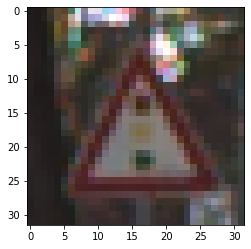

In [308]:
%%time
from PIL import Image
import glob
import matplotlib.pyplot as plt

# total # of images = 12630
X_train = []
X_test = []

for index, file in enumerate(glob.glob('GTSRB/Final_Test/Images/*ppm')):
    image = Image.open(file)
    resized_image = image.resize((32, 32))
    array = np.array(resized_image)
    if index < 10000:
        # Load image file to array:
        X_train.append(array)
    elif index < 12000 and index >= 10000:
        X_test.append(array)
    else:
        break
        
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# show image from dataset
print(X_train.shape)
plt.imshow(X_train[10].reshape(32, 32, 3))

### Tensorflow Flowers (Outlier Dataset)

In [310]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [311]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


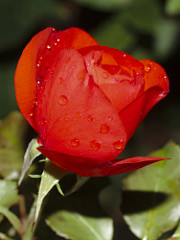

In [312]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

In [313]:
batch_size = 1000
img_height = 32
img_width = 32

In [314]:
flowers_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


In [315]:
class_names = flowers_ds.class_names
print(class_names)
print(birds_ds)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
<BatchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>


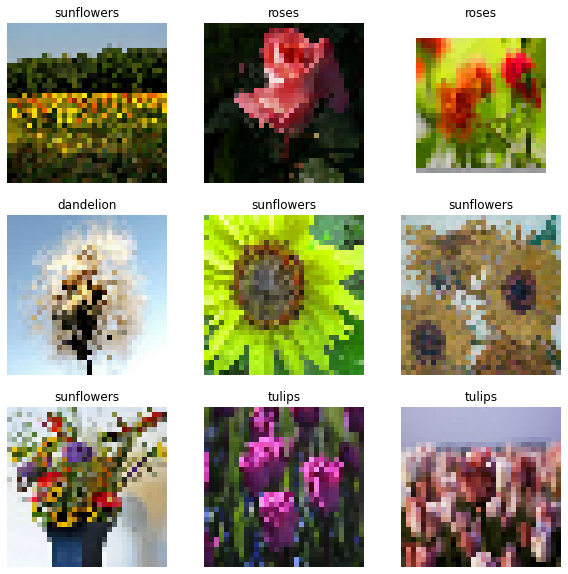

In [316]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in flowers_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [317]:
global flowers 

for image_batch, labels_batch in flowers_ds:
    flowers = image_batch.numpy().astype('float32') / 255
    break
    
print(len(flowers))
print(type(flowers))

1000
<class 'numpy.ndarray'>


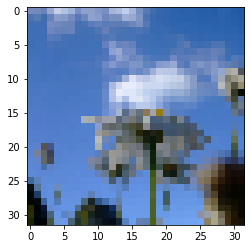

In [318]:
plt.imshow(flowers[5].reshape(32, 32, 3))

### Caltech Birds 2010 (Outlier Dataset)

In [409]:
bird_images, labels = tfds.as_numpy(tfds.load(
    'caltech_birds2010',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

INFO:absl:Load dataset info from /home/ec2-user/tensorflow_datasets/caltech_birds2010/0.1.1
INFO:absl:Reusing dataset caltech_birds2010 (/home/ec2-user/tensorflow_datasets/caltech_birds2010/0.1.1)
INFO:absl:Constructing tf.data.Dataset caltech_birds2010 for split test, from /home/ec2-user/tensorflow_datasets/caltech_birds2010/0.1.1


In [410]:
def resize(images, width, height, show_image=False):
    resized_images = []
    for image_array in images:
        image = Image.fromarray(image_array)
        if show_image:
            image.show()
        resized_image = image.resize((width, height))
        resized_image_array = np.array(resized_image)
        resized_images.append(resized_image_array)
    resized_images = np.asarray(resized_images)
    return resized_images

In [411]:
resized_bird_images = resize(bird_images, 32, 32)

print(type(resized_bird_images))
print(resized_bird_images.shape)

birds = resized_bird_images.astype('float32') / 255

<class 'numpy.ndarray'>
(3033, 32, 32, 3)


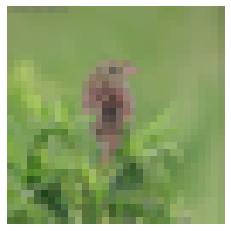

In [412]:
plt.imshow(birds[5])
plt.axis('off')
plt.show()

Note that some of the images in the birds dataset have zero-padding added. These images are still correctly identified as outliers.


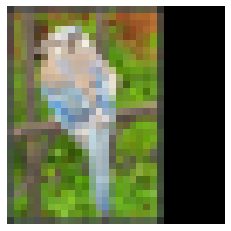

In [413]:
print("Note that some of the images in the birds dataset have zero-padding added. These images are still correctly identified as outliers.")
plt.imshow(birds[10])
plt.axis('off')
plt.show()

## Train Outlier Detector on GTSRB

In [358]:
load_outlier_detector = False

filepath = 'outlier_detector'  # change to (absolute) directory where model is downloaded
if load_outlier_detector:  # load pretrained outlier detector
    od = load_detector(filepath)
else:  # define model, initialize, train and save outlier detector
    encoding_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
          Flatten(),
          Dense(encoding_dim,)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(encoding_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierAE(threshold=.015,  # threshold for outlier score
                    encoder_net=encoder_net,  # can also pass AE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    )
    # train
    od.fit(X_train,
           epochs=75,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

157/157 [=] - 20s 128ms/step - loss: 0.0026


## Predict Outliers

In [399]:
X = X_train
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=95)
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.007575601469725365
New threshold: 0.007268747827038165


In [421]:
sample_size = 500

inlier_data = X_train[:sample_size]

inlier_od_preds = od.predict(inlier_data,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
# print(inlier_od_preds)

Inlier dataset: 


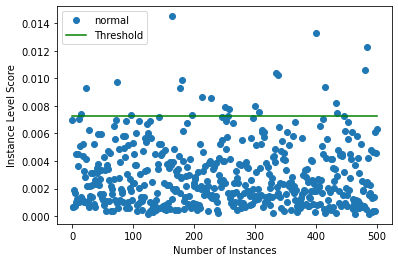

In [401]:
print("Inlier dataset: ")

target = np.zeros(inlier_data.shape[0],).astype(int) 
labels = ['normal', 'outlier']
plot_instance_score(inlier_od_preds, target, labels, od.threshold)

In [422]:
flower_outlier_data = flowers[:sample_size]

flower_od_preds = od.predict(flower_outlier_data,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
# print(flower_od_preds)

Outlier flowers dataset: 


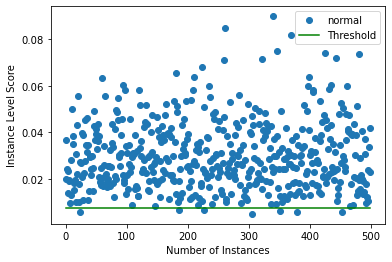

In [403]:
print("Outlier flowers dataset: ")

target = np.zeros(flower_outlier_data.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(flower_od_preds, target, labels, od.threshold)

In [426]:
bird_outlier_data = birds[:sample_size]

bird_od_preds = od.predict(bird_outlier_data,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
# print(bird_od_preds)

Outlier birds dataset: 


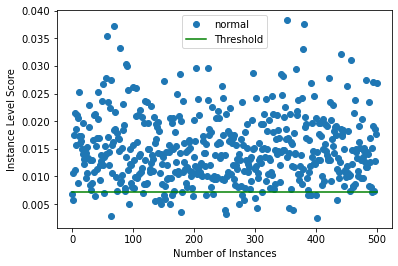

In [427]:
print("Outlier birds dataset: ")

target = np.zeros(bird_outlier_data.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(bird_od_preds, target, labels, od.threshold)

## Calculate Outlier Detector Accuracy

In [416]:
def wrong_predictions(inlier_od_preds, outlier_od_preds, sample_size):
    #false positives
    false_positive_indices = []
    for i, p in enumerate(inlier_od_preds["data"]["is_outlier"]):
        if p == 1:
            false_positive_indices.append(i)

    false_positive_scores = []
    for i in false_positive_indices:
        score = inlier_od_preds["data"]["instance_score"][i]
        false_positive_scores.append(score)

    false_positives = list(zip(false_positive_indices, false_positive_scores))
    # false_positive_rate = len(false_positives) / sample_size
    
    # false negatives
    false_negative_indices = []
    for i, p in enumerate(outlier_od_preds["data"]["is_outlier"]):
        if p == 0:
            false_negative_indices.append(i)

    false_negative_scores = []
    for i in false_negative_indices:
        score = outlier_od_preds["data"]["instance_score"][i]
        false_negative_scores.append(score)

    false_negatives = list(zip(false_negative_indices, false_negative_scores))
    # false_negative_rate = len(false_negatives) / sample_size
    
    return {"false_positives": false_positives, "false_negatives": false_negatives}

def accuracy(false_positives, false_negatives, total_predictions):
    correct_predictions = total_predictions - (len(false_positives) + len(false_negatives))
    accuracy = correct_predictions / total_predictions 
    return accuracy    

In [417]:
wrong_preds_flowers = wrong_predictions(inlier_od_preds, flower_od_preds, 100)
print("False positives and false negatives when using the flowers dataset: ", wrong_preds_flowers)

od_acc_flowers = accuracy(wrong_preds_flowers["false_positives"], wrong_preds_flowers["false_negatives"], sample_size * 2)
print("Outlier detection accuracy on flower dataset: ", od_acc_flowers)

False positives and false negatives when using the flowers dataset:  {'false_positives': [(15, 0.0074211373), (22, 0.009312696), (73, 0.009744159), (96, 0.007330999), (164, 0.01451088), (177, 0.009305871), (180, 0.009880737), (196, 0.0073458743), (213, 0.008677602), (227, 0.008581939), (250, 0.007894729), (256, 0.007298838), (257, 0.007773155), (299, 0.0079837805), (307, 0.007575371), (334, 0.010367892), (337, 0.010236621), (399, 0.013311933), (414, 0.00940487), (433, 0.008194982), (435, 0.0074919756), (480, 0.010583875), (484, 0.012256443)], 'false_negatives': [(23, 0.0055135055), (185, 0.006762546), (227, 0.00653775), (306, 0.004886671), (352, 0.0060328287), (379, 0.0057673356), (453, 0.005743284)]}
Outlier detection accuracy on flower dataset:  0.97


In [418]:
wrong_preds_birds = wrong_predictions(inlier_od_preds, bird_od_preds, 100)
print("False positives and false negatives when using the birds dataset: ", wrong_preds_birds)

od_acc_birds = accuracy(wrong_preds_birds["false_positives"], wrong_preds_birds["false_negatives"], sample_size * 2)

print("Outlier detection accuracy on bird dataset: ", od_acc_birds)

False positives and false negatives when using the birds dataset:  {'false_positives': [(15, 0.0074211373), (22, 0.009312696), (73, 0.009744159), (96, 0.007330999), (164, 0.01451088), (177, 0.009305871), (180, 0.009880737), (196, 0.0073458743), (213, 0.008677602), (227, 0.008581939), (250, 0.007894729), (256, 0.007298838), (257, 0.007773155), (299, 0.0079837805), (307, 0.007575371), (334, 0.010367892), (337, 0.010236621), (399, 0.013311933), (414, 0.00940487), (433, 0.008194982), (435, 0.0074919756), (480, 0.010583875), (484, 0.012256443)], 'false_negatives': [(0, 0.006871253), (1, 0.0057598674), (38, 0.0064955056), (52, 0.0069536935), (63, 0.00291772), (93, 0.0050122635), (116, 0.0069616246), (135, 0.0055368296), (143, 0.0058162105), (146, 0.0049752393), (151, 0.0067229173), (152, 0.0058470876), (161, 0.0049780593), (164, 0.006637469), (179, 0.0035433026), (198, 0.0065394207), (219, 0.0065779), (231, 0.006852554), (251, 0.0038831301), (252, 0.0031995773), (273, 0.004959118), (278, 0.0